### CAPM-Based Interpretation of Risk Factors
### 1. Introduction

This simulation is a multi-factor modeling framework inspired by the Capital Asset Pricing Model (CAPM).

Reference:
- John C. Hull, *Risk Management and Financial Institutions*, 5th Edition, Wiley.

While traditional CAPM considers market beta as the one driver of return, this approach extends the logic to include more factors such as:
- Equity market index (e.g. SPY)
- Sector index (e.g. XLK for technology exposure)
- Interest rate proxy (e.g. TLT)

Portfolio sensitivity (beta) to these risk factors is estimated using historical return data via linear regression. These beta coefficients are then applied to simulated risk factor returns to generate portfolio-level return paths for Monte Carlo VaR estimation.


## 1.1 Rationale for Risk Factors

The following risk factors are selected based on their financial relevance to a technology-heavy portfolio and are incorporated into the modeling framework:

- **Market (`SPY`)**: Represents the overall U.S. equity market as general equity market movements. It is also widely recognized as a benchmark for passive investment strategies.

- **Tech (`XLK`)**: This ETF represents the technology sector and is chosen because this portfolio is tech-centric composition. It can be replaced by `XLF` or another sector ETF if the portfolio focus shifts.

- **IR (`TLT`)**: A long-duration Treasury bond ETF used as an interest rate factor. It is included because tech stocks are typically more affected by long-term rate movements.

- **Mtum (`MTUM`)**: An ETF tracking stocks with strong recent performance, following a momentum-based strategy.

- **Vol (`^VIX`)**: This index is for market volatility and can explain how asset returns react to unexpected situations or market stress.

- **Value (`VLUE`)**: An ETF that focuses on stocks with relatively low valuation metrics, often measured by metrics like P/E ratio.

- **Growth (`IWF`)**: An ETF that includes U.S. stocks with high revenue or earnings growth. It often overlaps with tech stocks and is used to reflect growth-style exposure in the portfolio.

Note: Growth and value factors may be highly correlated due to their construction methodology. While both are included to reflect style exposures relevant to tech-driven portfolios, the risk of multicollinearity is acknowledged. Correlation and VIF check will be performed later.

## 2. Factor Modeling and Simulation 

This section presents a two-step framework for modeling portfolio risk using a multi-factor extension of the Capital Asset Pricing Model (CAPM). 

Step1: the portfolio return is regressed on market risk factors using linear regression to estimate factor sensitivities (betas). This approach captures how the portfolio responds to systematic drivers such as market, sector, interest rates, and style exposures.

Step2: Monte Carlo simulation is applied to the selected risk factors. Correlated factor returns are generated based on a covariance matrix estimated from historical data. These simulated returns, combined with the estimated betas, are used to construct portfolio return distributions and compute Value-at-Risk (VaR).

### 2.1 Factor Regression and Selection

To quantify the portfolio’s exposure to systematic risk factors, historical portfolio returns are regressed on the selected factor returns using ordinary least squares (OLS) regression. The initial model includes all factors, and the resulting R² of approximately 0.90 indicates strong explanatory power.

To improve robustness and mitigate potential multicollinearity, the model is refined as follows:

- Factors with statistically insignificant coefficients (high p-values) are removed.
- Variance Inflation Factor (VIF) is calculated to test multicollinearity. 

In practice, some degree of multicollinearity is often tolerated to preserve economic interpretability, which means factors with high VIF values do not necessarily need to be excluded. However, in this simulation, those factors were removed to simplify the model and ensure statistical clarity, especially since the remaining factor set still provided strong explanatory power, with a high R².

A second linear regression is performed on the reduced set of factors that passed both the p-value threshold for statistical significance and the VIF threshold for multicollinearity. The updated model maintains strong explanatory power, with an R² comparable to the initial full-factor model. The beta coefficients estimated from this regression are used as inputs in the Monte Carlo simulation.

### 2.2 Simulating Correlated Risk Factor Returns

A multivariate normal distribution is employed for Monte Carlo simulation. The mean vector and covariance matrix are estimated from historical returns of the selected risk factors to ensure that the simulated returns reflect their historical co-movements.

The simulated factor returns will later be combined with the portfolio’s beta exposures for Value-at-Risk estimation.

### 2.3 Constructing Simulated Portfolio Returns

Once risk factor return paths have been generated through Monte Carlo simulation, they are transformed into portfolio returns using the beta exposures estimated in Section 2.1.

Each simulated portfolio return is calculated as a linear combination of the simulated factor returns, weighted by the portfolio’s beta to each factor:

    Simulated Portfolio Return = β₁ × Factor₁ + β₂ × Factor₂ + ... + β_k × Factor_k

Where:
- β represents the portfolio's sensitivity (beta) to each factor
- Factor_i is the simulated return of the i-th risk factor for that scenario

This process generates a full distribution of 1-day simulated portfolio returns, which incorporates both the correlation structure of the risk factors and the portfolio’s exposures.

This return distribution serves as the basis for calculating the 99% Value-at-Risk in the next step.

## 3. Monte Carlo VaR Estimation

The 1-day 99% Value-at-Risk (VaR) is estimated as the 1st percentile of the simulated portfolio return distribution generated in Section 2.3.

This approach follows the standard Monte Carlo VaR methodology widely recognized in both regulatory frameworks and industry practice.

## 4. Backtesting and Basel III Evaluation

To evaluate the accuracy of the Monte Carlo VaR model, backtesting is performed by comparing the predicted 1-day 99% VaR from Monte Carlo simulation against actual portfolio returns over a 1-year test period(approximately 250 trading days), consistent with the Basel III framework.

Each instance in which the actual return falls below the estimated VaR is recorded as a breach, or exception. The total number of exceptions is counted to assess model performance according to the Basel III framework.

Under the Basel guidelines:

- **Green Zone**: 0 to 4 exceptions (model accepted)
- **Yellow Zone**: 5 to 9 exceptions (model conditionally accepted, increased multiplier)
- **Red Zone**: 10 or more exceptions (model rejected or subjected to supervisory review)

This traffic light classification provides a standardized regulatory interpretation of how effectively the model captures downside risk. The number of  observed exceptions is compared to the threshold to determine the appropriate regulatory zone.

📖 Reference: [BCBS Traffic Light Backtesting Framework](https://www.bis.org/publ/bcbs22.htm)

### Appendix: Python Coding 

In [1]:
import json

config = {
    "tickers": ['AAPL', 'MSFT', 'NVDA', 'GOOG', 'AMD'],
    "weights": [0.3, 0.25, 0.2, 0.15, 0.1],
    "start": "2023-01-01",
    "end": "2025-12-31",
    "train_start": "2023-01-01",
    "train_end": "2024-04-30",
    "test_start": "2024-05-01",
    "test_end": "2025-05-01",
    "confidence":0.99
}

with open("portfolio_config.json", "w") as f:
    json.dump(config, f, indent=9)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
from IPython.display import Markdown
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:

def get_price_data(tickers, start_date="2020-01-01", end_date="2024-12-31"):
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust = True, progress=False)['Close']
    return data

In [4]:
with open("portfolio_config.json", "r") as f:
    config = json.load(f)

tickers = config["tickers"]
weights = config["weights"]
start = config["start"]
end = config["end"]
train_start = config["train_start"]
train_end = config["train_end"]
test_start = config["test_start"]
test_end = config["test_end"]
confidence = config["confidence"]

Port1_Ticker_P = get_price_data(tickers, train_start, train_end)
Port1_Ticker_P.head()

Ticker,AAPL,AMD,GOOG,MSFT,NVDA
Date,,,,,
2023-01-03,123.470596,64.019997,89.277138,235.240036,14.303277
2023-01-04,124.744125,64.660004,88.291809,224.949890,14.736924
2023-01-05,123.421257,62.330002,86.360947,218.282883,14.253322
2023-01-06,127.962425,63.959999,87.744400,220.855392,14.846834
2023-01-09,128.485657,67.239998,88.381386,223.005737,15.615206


In [5]:
risk_factor_proxies = {
    'Market': 'SPY',     # SP500
    'Tech': 'XLK',       # Tech sector risk
    'IR': 'TLT',         # Interest rate sensitivity
    'Mtum': 'MTUM',      # Momentum factor
    'Vol': '^VIX',       # Volatility (non-tradable index)
    'Value': 'VLUE',     # Value-style equities
    'Growth': 'IWF'      # Growth-style equities
}

In [6]:
Factor_Tickers = list(risk_factor_proxies.values())
##tickers is the portfolio tickers, which is defined from the config and used for part 1 (portfolio1)
All_Tickers = tickers +Factor_Tickers

In [7]:
def compute_log_returns(price_df):
    log_returns = np.log(price_df / price_df.shift(1))
    return log_returns.dropna()

In [8]:
Price_All = get_price_data(All_Tickers, train_start, train_end)

Price_All = get_price_data(All_Tickers, train_start, train_end)
Log_All_R = compute_log_returns(Price_All)

In [9]:
##Linear Regression
Portfolio_R = Log_All_R[tickers]  
PortfolioReturn = Portfolio_R @ weights #y

Factor_R = Log_All_R[Factor_Tickers]  #x 

In [10]:
def RunOLSRegression(PortfolioReturn: pd.Series,
                     FactorReturns: pd.DataFrame) -> pd.DataFrame:

    X = sm.add_constant(FactorReturns)
    y = PortfolioReturn

    model = sm.OLS(y, X).fit()

    result_df = pd.DataFrame({
        'Factor': model.params.index,
        'Beta': model.params.values,
        'T-Stat': model.tvalues.values,
        'P-Value': model.pvalues.values
    })

    result_df = result_df[result_df['Factor'] != 'const']
    result_df['P-Value'] = result_df['P-Value'].round(4)
    result_df = result_df[['Factor', 'Beta', 'T-Stat', 'P-Value']]

    return result_df

In [11]:
def GetPortR_Square(PortfolioReturn: pd.DataFrame,
                    FactorReturns: pd.DataFrame) -> tuple[float, float]:

    X = sm.add_constant(FactorReturns)
    y = PortfolioReturn
    Model = sm.OLS(y, X).fit()
    return Model.rsquared.round(2), Model.rsquared_adj.round(2)

In [12]:
GetPortR_Square(PortfolioReturn, Factor_R)

(0.92, 0.91)

In [13]:
regression_result = RunOLSRegression(PortfolioReturn, Factor_R)

In [14]:
regression_result 

,Factor,Beta,T-Stat,P-Value
1,SPY,-0.503135,-2.258353,0.0246
2,XLK,0.808601,11.249052,0.0000
3,TLT,-0.020340,-0.895380,0.3713
4,MTUM,-0.198960,-4.705969,0.0000
5,^VIX,-0.007697,-1.141535,0.2545
6,VLUE,-0.231632,-2.960483,0.0033
7,IWF,1.105319,6.485180,0.0000


In [15]:
def CalculateVIF(FactorReturns: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate Variance Inflation Factor (VIF) for each factor.
    """
    vif_data = pd.DataFrame()
    vif_data["Factor"] = FactorReturns.columns
    vif_data["VIF"] = [variance_inflation_factor(FactorReturns.values, i)
                       for i in range(FactorReturns.shape[1])]
    return vif_data

In [16]:
VIF_result = CalculateVIF(Factor_R)

In [17]:
VIF_result

,Factor,VIF
0,SPY,54.166601
1,XLK,12.143214
2,TLT,1.046677
3,MTUM,2.783501
4,^VIX,2.200322
5,VLUE,8.193423
6,IWF,49.713392


In [18]:
FactorR = Factor_R.drop(columns=["TLT","IWF","^VIX","SPY"]) 


In [19]:
GetPortR_Square(PortfolioReturn, FactorR)

(0.89, 0.89)

In [20]:
regression_result = RunOLSRegression(PortfolioReturn, FactorR)

In [21]:
regression_result 

,Factor,Beta,T-Stat,P-Value
1,XLK,1.390298,40.554670,0.0000
2,MTUM,-0.083370,-1.987777,0.0477
3,VLUE,-0.305527,-7.512107,0.0000


In [22]:
FactorR.corr()

Ticker,XLK,MTUM,VLUE
Ticker,,,
XLK,1.000000,0.699361,0.608388
MTUM,0.699361,1.000000,0.610275
VLUE,0.608388,0.610275,1.000000


In [23]:
VIF_result = CalculateVIF(FactorR)
VIF_result 

,Factor,VIF
0,XLK,2.192072
1,MTUM,2.202151
2,VLUE,1.779852


In [24]:
regression_result = RunOLSRegression(PortfolioReturn, FactorR)
regression_result

,Factor,Beta,T-Stat,P-Value
1,XLK,1.390298,40.554670,0.0000
2,MTUM,-0.083370,-1.987777,0.0477
3,VLUE,-0.305527,-7.512107,0.0000


In [25]:
def SimulateFactors(FactorReturns: pd.DataFrame, NSim: int = 10000):
    """
    Simulate multivariate normal factor returns based on historical covariance and mean.
    """
    assert isinstance(NSim, int), "NSim must be an integer"

    FactorCov = FactorReturns.cov().values
    FactorMean = FactorReturns.mean().values
    Simulated = np.random.multivariate_normal(mean=FactorMean, cov=FactorCov, size=NSim)

    return pd.DataFrame(Simulated, columns=FactorReturns.columns)

In [26]:
model = sm.OLS(PortfolioReturn, sm.add_constant(FactorR)).fit()
PortfolioBeta = model.params.drop("const")

Simulated_Factor_DF = SimulateFactors(FactorR, 1000)[PortfolioBeta.index]
SimulatedPortfolioReturn = Simulated_Factor_DF @ PortfolioBeta.values

In [27]:
Simulated_Factor_DF

Ticker,XLK,MTUM,VLUE
0,-0.012563,-0.001478,0.001734
1,0.009045,0.008105,0.014333
2,0.016120,0.003774,-0.004484
3,-0.002723,0.004274,-0.003568
4,0.007313,-0.003794,-0.000228
...,...,...,...
995,-0.000794,-0.007955,-0.012083
996,0.003754,0.015607,0.005239
997,0.007227,0.008665,0.015041
998,-0.002416,0.019038,-0.000156


In [28]:
SimulatedPortfolioReturn

0     -0.017873
1      0.007520
2      0.023467
3     -0.003053
4      0.010553
         ...   
995    0.003251
996    0.002318
997    0.004730
998   -0.004898
999    0.011833
Length: 1000, dtype: float64

In [29]:
SimulatedPortfolioVaR = np.percentile(SimulatedPortfolioReturn, (1-confidence)*100)
print(f"{int(confidence*100)}% VaR: {SimulatedPortfolioVaR:.2%}")

99% VaR: -3.16%


In [30]:
SimulatedPortfolioReturn

0     -0.017873
1      0.007520
2      0.023467
3     -0.003053
4      0.010553
         ...   
995    0.003251
996    0.002318
997    0.004730
998   -0.004898
999    0.011833
Length: 1000, dtype: float64

In [31]:
Log_All_R

Ticker,AAPL,AMD,GOOG,IWF,MSFT,MTUM,NVDA,SPY,TLT,VLUE,XLK,^VIX
Date,,,,,,,,,,,,
2023-01-04,0.010262,0.009947,-0.011098,0.003521,-0.044729,-0.000906,0.029868,0.007690,0.013607,0.015567,0.002593,-0.039640
2023-01-05,-0.010661,-0.036700,-0.022112,-0.016301,-0.030086,-0.000698,-0.033366,-0.011479,0.004172,-0.005090,-0.019612,0.020239
2023-01-06,0.036133,0.025815,0.015892,0.023446,0.011716,0.016601,0.040797,0.022673,0.018229,0.025087,0.028874,-0.061042
2023-01-09,0.004081,0.050010,0.007233,0.005198,0.009689,-0.013468,0.050459,-0.000567,0.005310,-0.002544,0.011558,0.038984
2023-01-10,0.004446,0.011974,0.004943,0.007379,0.007588,0.005132,0.017821,0.006989,-0.016688,0.007086,0.006163,-0.065358
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-23,0.006371,0.024128,0.012395,0.014705,0.016351,0.021221,0.035881,0.011797,0.000337,0.007911,0.014718,-0.076654
2024-04-24,0.012622,-0.003487,0.007352,0.000185,0.003649,-0.004590,-0.033883,-0.000475,-0.007101,0.003108,0.004555,0.017688
2024-04-25,0.005134,0.013224,-0.019747,-0.006314,-0.024800,-0.004611,0.036416,-0.003806,-0.007038,-0.006031,-0.002174,-0.038294


In [32]:
test_start = config["test_start"]
test_end = config["test_end"]

test_prices = get_price_data(tickers, test_start, test_end)
test_returns = compute_log_returns(test_prices)
test_P_returns = test_returns[tickers]  
test_P_return = test_P_returns @ weights

In [33]:
test_P_return 

Date
2024-05-02    0.018841
2024-05-03    0.033183
2024-05-06    0.012984
2024-05-07   -0.003001
2024-05-08   -0.001136
                ...   
2025-04-24    0.029008
2025-04-25    0.017130
2025-04-28   -0.004945
2025-04-29    0.003215
2025-04-30    0.002663
Length: 249, dtype: float64

In [34]:
def backtest_VaR(real_returns, VaR):
    violations = real_returns < VaR
    num_violations = violations.sum()
    total_days = len(real_returns)
    violation_rate = num_violations / total_days

    if num_violations <= 4:
        zone = "Green"
    elif num_violations <= 9:
        zone = "Yellow"
    else:
        zone = "Red"

    return {
        "violations": int(num_violations),
        "total": total_days,
        "rate": f"{round(violation_rate * 100, 2)}%",
        "zone": zone
    }

In [35]:
backtest_VaR(test_P_return , SimulatedPortfolioVaR)

{'violations': 13, 'total': 249, 'rate': '5.22%', 'zone': 'Red'}

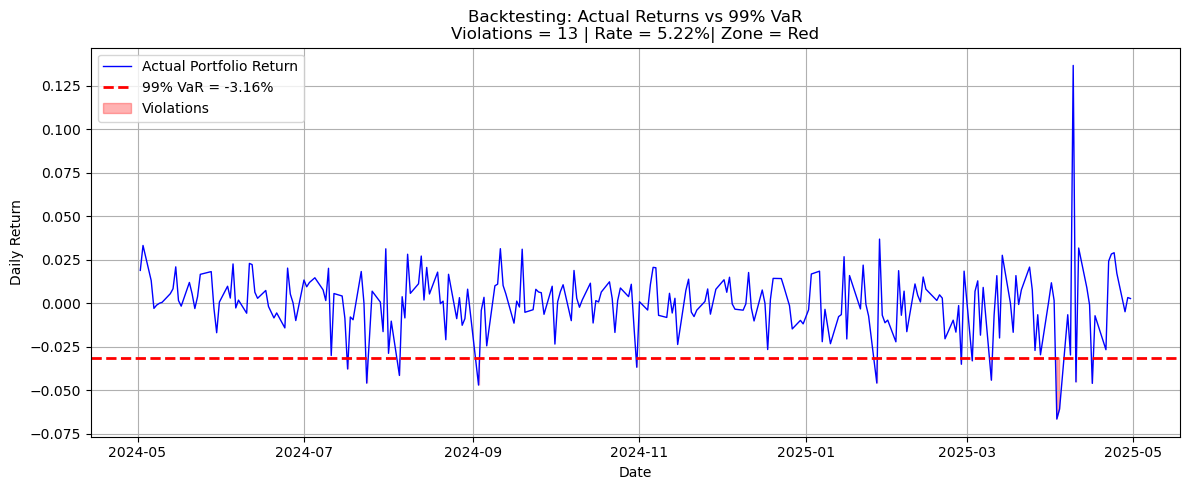

In [36]:
x = test_P_return.index
y = test_P_return.values.astype("float64")
VaR_line = SimulatedPortfolioVaR
y2 = np.full_like(y, VaR_line)
mask = y < VaR_line


result = backtest_VaR(test_P_return, SimulatedPortfolioVaR)


plt.figure(figsize=(12, 5))
plt.plot(x, y, label="Actual Portfolio Return", color="blue", linewidth=1)
plt.axhline(y=VaR_line, color="red", linestyle="--", linewidth=2,
            label=f"99% VaR = {VaR_line:.2%}")
plt.fill_between(x, y, y2, where=mask, color='red', alpha=0.3, label="Violations")

plt.title(f"Backtesting: Actual Returns vs 99% VaR\n"
          f"Violations = {result['violations']} | "
          f"Rate = {result['rate']}| Zone = {result['zone']}")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
Markdown(f"""
### Output: Backtest Result Summary

- Total backtesting days: **{result['total']}**
- VaR threshold (99%): **{SimulatedPortfolioVaR:.2%}**
- Violations: **{result['violations']}**  
- Violation rate: **{result['rate']}**

**Basel zone**: `{result['zone']}`  
→ Based on the number of violations, this model falls in the **{result['zone']} zone** under the Basel backtesting framework.
""")


### Output: Backtest Result Summary

- Total backtesting days: **249**
- VaR threshold (99%): **-3.16%**
- Violations: **13**  
- Violation rate: **5.22%**

**Basel zone**: `Red`  
→ Based on the number of violations, this model falls in the **Red zone** under the Basel backtesting framework.
